In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
img_uri = 'https://sandmines.s3.us-west-1.amazonaws.com/test/sone_s2_rgb_bands_4326.tif'
labelbox_export_uri = "https://sandmines.s3.us-west-1.amazonaws.com/test/Sone-Dehri-polygons.ndjson"
geojson_path = "../data/sandmines_dummy_example.geojson"

## Prepare Dateset

First, convert the output of labelbox into a geojson. Store the geojson in the local file system.  

In [3]:
from urllib.request import urlopen
import json
from pprint import pprint

labelbox_export_data = json.loads(
    urlopen(labelbox_export_uri).read()
)
labelbox_projects = list(labelbox_export_data['projects'].values())

# We expect that there exist only one "project"
assert len(labelbox_projects) == 1    

labels = labelbox_projects[0]['labels']

# We expect that there exist only one "label"
assert len(labels) == 1    

objects = labels[0]['annotations']['objects']
polygons = [o['geojson'] for o in objects]

geojson_out = {
    "type": "FeatureCollection",
    "features": [
        {"geometry": polygon}
        for polygon in polygons
    ]
}

with open(geojson_path, 'w') as file:
    json.dump(geojson_out, file, indent=2)

Setup rastervision SemanticSegmentationSlidingWindowGeoDataset

In [4]:
from rastervision.core.data import (
    ClassInferenceTransformer, GeoJSONVectorSource,
    RasterioSource, RasterizedSource, Scene, SemanticSegmentationLabelSource
)
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset
import albumentations as A

from config import CLASS_CONFIG_BINARY_SAND as class_config

img_raster_source = RasterioSource(img_uri, allow_streaming=False)

vector_source = GeoJSONVectorSource(
    geojson_path,
    img_raster_source.crs_transformer,
    ignore_crs_field=True,
    vector_transformers=[
        ClassInferenceTransformer(
            default_class_id=class_config.get_class_id('sandmine'))]
)

label_raster_source = RasterizedSource(
    vector_source,
    background_class_id=class_config.null_class_id,
    extent=img_raster_source.extent
)

label_source = SemanticSegmentationLabelSource(
    label_raster_source, class_config=class_config
)

scene = Scene(0, img_raster_source, label_source)

data_augmentation_transform = A.Compose([
    A.Flip(),
    A.CoarseDropout(max_height=64, max_width=64, max_holes=5)
])

ds = SemanticSegmentationSlidingWindowGeoDataset(scene, 450, 50)
ds_with_augment = SemanticSegmentationSlidingWindowGeoDataset(
    scene, 450, 50, transform=data_augmentation_transform
)

2023-07-06 17:47:46:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/sandmines.s3.us-west-1.amazonaws.com/test/sone_s2_rgb_bands_4326.tif.


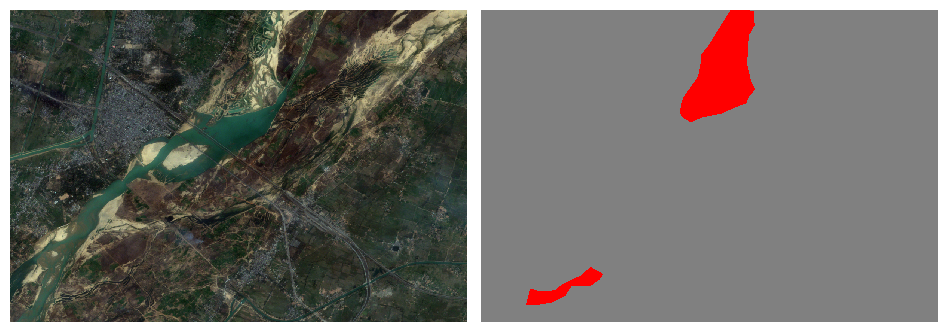

In [5]:
from utils.visualizing import show_rgb_with_labels

show_rgb_with_labels(
    ds.scene.raster_source[:, :],
    ds.scene.label_source[:,:],
    class_config.colors
)

In [ ]:
from utils.visualizing import show_windows, show_labels, show_image

show_windows(
    ds.scene.raster_source[:, :],
    ds.windows,
    title='Sliding windows'
)

In [ ]:
from rastervision.pytorch_learner import SemanticSegmentationVisualizer

viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

x, y = viz.get_batch(ds_with_augment, 5)
viz.plot_batch(x, y, show=True)

## Train

Note that we train and validate on the same data. The only difference is that the training data gets augmented. This is only for dummy demonstrating purposes.

In [8]:
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig, SolverConfig, SemanticSegmentationLearnerConfig, SemanticSegmentationLearner
from models.simple_segmentation import SimpleSegmentationNet

model = SimpleSegmentationNet(2)

data_cfg = SemanticSegmentationGeoDataConfig(
    class_names=class_config.names,
    class_colors=class_config.colors,
    num_workers=0, # increase to use multi-processing
)

solver_cfg = SolverConfig(
    batch_sz=8,
    lr=3e-2,
    class_loss_weights=[1., 10.]
)

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir='../out/model_dummy_01',
    model=model,
    train_ds=ds_with_augment,
    valid_ds=ds, 
)
learner.log_data_stats()

2023-07-06 17:48:17:rastervision.pytorch_learner.learner: INFO - train_ds: 260 items
2023-07-06 17:48:17:rastervision.pytorch_learner.learner: INFO - valid_ds: 260 items


learner setup_training()
loss_def_path None
setup_loss()
loss_def_path None
build_loss()
{}
Loss:
CrossEntropyLoss()


In [12]:
learner.train(epochs=3)

2023-07-06 17:50:18:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 3
2023-07-06 17:50:18:rastervision.pytorch_learner.learner: INFO - epoch: 3


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

2023-07-06 17:50:36:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.9595925211906433,
 'avg_precision': 0.9466082453727722,
 'avg_recall': 0.9729379415512085,
 'epoch': 3,
 'other_f1': 0.9862833619117737,
 'other_precision': 0.9729379415512085,
 'other_recall': 1.0,
 'sandmine_f1': 0.0,
 'sandmine_precision': 0.0,
 'sandmine_recall': 0.0,
 'train_loss': 0.011780008902916542,
 'train_time': '0:00:09.360999',
 'val_loss': 0.011039459146559238,
 'valid_time': '0:00:08.876238'}
2023-07-06 17:50:36:rastervision.pytorch_learner.learner: INFO - epoch: 4


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

2023-07-06 17:50:55:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.9595925211906433,
 'avg_precision': 0.9466082453727722,
 'avg_recall': 0.9729379415512085,
 'epoch': 4,
 'other_f1': 0.9862833619117737,
 'other_precision': 0.9729379415512085,
 'other_recall': 1.0,
 'sandmine_f1': 0.0,
 'sandmine_precision': 0.0,
 'sandmine_recall': 0.0,
 'train_loss': 0.01167605840242826,
 'train_time': '0:00:09.406709',
 'val_loss': 0.010969279333949089,
 'valid_time': '0:00:08.873540'}
2023-07-06 17:50:55:rastervision.pytorch_learner.learner: INFO - epoch: 5


Training:   0%|          | 0/26 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

2023-07-06 17:51:13:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.9595925211906433,
 'avg_precision': 0.9466082453727722,
 'avg_recall': 0.9729379415512085,
 'epoch': 5,
 'other_f1': 0.9862833619117737,
 'other_precision': 0.9729379415512085,
 'other_recall': 1.0,
 'sandmine_f1': 0.0,
 'sandmine_precision': 0.0,
 'sandmine_recall': 0.0,
 'train_loss': 0.011097944699800931,
 'train_time': '0:00:09.349885',
 'val_loss': 0.010928547941148281,
 'valid_time': '0:00:08.855283'}


## Evaluate

In [13]:
from rastervision.core.data import SemanticSegmentationLabels

predictions = learner.predict_dataset(
    ds,
    raw_out=True,
    numpy_out=True,
    progress_bar=True
)

pred_labels = SemanticSegmentationLabels.from_predictions(
    ds.windows,
    predictions,
    smooth=True,
    extent=ds.scene.extent,
    num_classes=len(class_config)
)

scores = pred_labels.get_score_arr(pred_labels.extent)
predicted_mine_probability = scores[class_config.get_class_id('sandmine')]

Predicting:   0%|          | 0/260 [00:00<?, ?it/s]

#### Visualize predictions
(Note that we are predicting on the training dataset)

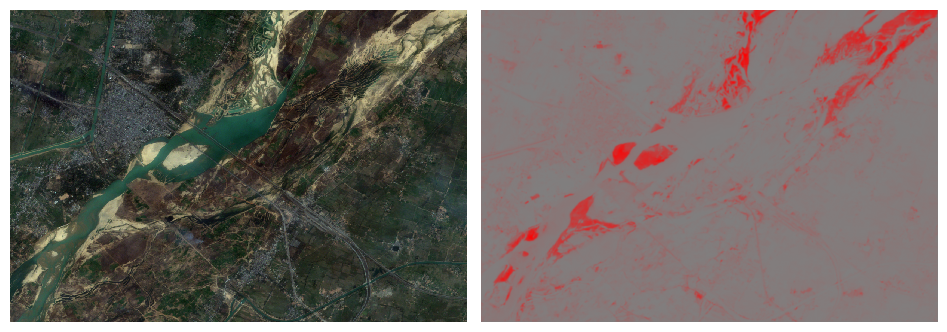

In [14]:
from utils.visualizing import show_rgb_with_labels

show_rgb_with_labels(
    ds.scene.raster_source[:, :],
    predicted_mine_probability,
    #class_config.colors
)

In [15]:
pred_labels.save(
    '../out/predictions_dummy/',
    ds.scene.raster_source.crs_transformer,
    class_config=class_config
)

2023-07-06 17:51:37:rastervision.core.data.label_store.semantic_segmentation_label_store: INFO - Old scores found. Merging with current scores.
2023-07-06 17:51:37:rastervision.core.data.label_store.semantic_segmentation_label_store: INFO - Loading scores...


Saving pixel labels:   0%|          | 0/2 [00:00<?, ?it/s]

Saving pixel scores:   0%|          | 0/2 [00:00<?, ?it/s]